1. Imports & Global Settings (Bayesian + NeuralNet Hybrid)

In [1]:
# 1) Imports & minimal global setup  — ONLY what's necessary

import numpy as np
import pandas as pd

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models (base + meta)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

# Time-series aware cross-validation
from sklearn.model_selection import TimeSeriesSplit

# Bayesian hyperparameter optimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

# Metrics (used later; import here to avoid scattered imports)
from sklearn.metrics import accuracy_score, balanced_accuracy_score


2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]

file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 23-24.csv"
df = pd.read_csv(file_path, usecols=usecols)

# Assign match index and round (10 matches per round in PL)
df['MatchIndex'] = df.index + 1
df['Round'] = np.ceil(df['MatchIndex'] / 10).astype(int)

# Extract hour, bucket into time of day
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

# --- NEW: cleanup to avoid NaN/inf propagation later ---
df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("Loaded shape:", df.shape)

Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# 3.1 Targets
df['Outcome'] = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5'] = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2 Implied probabilities from Bet365 odds (row-wise normalization)
for s in ['H','D','A']:
    df[f'ImpProb_{s}'] = 1.0 / df[f'B365{s}']

prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
row_sum = df[prob_cols].sum(axis=1)
df.loc[row_sum > 0, prob_cols] = df.loc[row_sum > 0, prob_cols].div(row_sum[row_sum > 0], axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
ou_sum = df[['ImpOver2.5','ImpUnder2.5']].sum(axis=1)
df.loc[ou_sum > 0, ['ImpOver2.5','ImpUnder2.5']] = (
    df.loc[ou_sum > 0, ['ImpOver2.5','ImpUnder2.5']].div(ou_sum[ou_sum > 0], axis=0)
)

# 3.3 Rolling forms (3-match averages, shifted to avoid leakage)
df['HomeForm3'] = (
    (df['FTHG'] - df['FTAG'])
    .groupby(df['HomeTeam'])
    .apply(lambda s: s.shift(1).rolling(3, min_periods=1).apply(lambda x: np.sign(x).mean(), raw=True))
    .reset_index(level=0, drop=True)
)

df['AwayForm3'] = (
    (df['FTAG'] - df['FTHG'])
    .groupby(df['AwayTeam'])
    .apply(lambda s: s.shift(1).rolling(3, min_periods=1).apply(lambda x: np.sign(x).mean(), raw=True))
    .reset_index(level=0, drop=True)
)

# 3.4 Streaks (from previous outcomes, shifted to avoid leakage)
def streak_from_signed_outcome(s):
    run, out = 0, []
    for v in s:
        if pd.isna(v) or v == 0:
            run = 0
        else:
            v = np.sign(v)
            run = run + v if (len(out) and out[-1] != 0 and np.sign(out[-1]) == v) else v
        out.append(run)
    return pd.Series(out, index=s.index)

df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .apply(lambda s: streak_from_signed_outcome(s.shift(1)))
      .reset_index(level=0, drop=True)
)

df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .apply(lambda s: streak_from_signed_outcome((-s).shift(1)))
      .reset_index(level=0, drop=True)
)

# 3.5 Odds spread & interaction
df['OddsSpread']  = df['ImpProb_H'] - df['ImpProb_A']
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.6 Referee bias (historical home-win rate up to previous match)
ref_cum_homewins = (
    df.assign(HomeWin=df['Outcome'].eq(1).astype(int))
      .groupby('Referee')['HomeWin']
      .cumsum()
      .shift(1)
)
ref_counts = df.groupby('Referee').cumcount()
df['RefBias'] = (ref_cum_homewins / ref_counts.replace(0, np.nan)).fillna(0.5)

# 3.7 Head-to-head last result (from current home-team perspective)
df['PairKey'] = df.apply(lambda r: tuple(sorted([r['HomeTeam'], r['AwayTeam']])), axis=1)
_h2h_last = {}
def _get_prev_h2h(row):
    key = row['PairKey']
    prev = _h2h_last.get(key, 0.0)
    sign = 1 if row['HomeTeam'] == key[0] else -1
    _h2h_last[key] = row['Outcome'] * sign  # update memory with current result
    return prev if row['HomeTeam'] == key[0] else -prev
df['H2H_Last'] = df.apply(_get_prev_h2h, axis=1)

# 3.8 Previous-round league positions (simple cumulative points model)
home_pts = df['Outcome'].map({1:3, 0:1, -1:0})
away_pts = df['Outcome'].map({1:0, 0:1, -1:3})

_tmp_rows = []
for i, r in df.iterrows():
    _tmp_rows.append({'Team': r['HomeTeam'], 'Round': r['Round'], 'Pts': home_pts.iloc[i]})
    _tmp_rows.append({'Team': r['AwayTeam'], 'Round': r['Round'], 'Pts': away_pts.iloc[i]})

_table = pd.DataFrame(_tmp_rows)
_table['CumPts'] = _table.groupby('Team')['Pts'].cumsum()
_table['Pos']    = _table.groupby('Round')['CumPts'].rank(method='min', ascending=False)

_prev_pos = _table[['Team','Round','Pos']].rename(columns={'Round':'PrevRound','Pos':'PrevPos'})
_prev_pos['PrevRound'] += 1

df = df.merge(_prev_pos, left_on=['HomeTeam','Round'], right_on=['Team','PrevRound'], how='left')
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(_prev_pos, left_on=['AwayTeam','Round'], right_on=['Team','PrevRound'], how='left')
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

# 3.9 Rolling team statistics (3-match means, using only past data via shift(1))
# Home-side rolling stats
for s in ['HS','HST','HF','HC','HY','HR']:
    df[f'Home_{s}_3'] = (
        df.groupby('HomeTeam')[s]
          .apply(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
          .reset_index(level=0, drop=True)
    )
# Away-side rolling stats
for s in ['AS','AST','AF','AC','AY','AR']:
    df[f'Away_{s}_3'] = (
        df.groupby('AwayTeam')[s]
          .apply(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
          .reset_index(level=0, drop=True)
    )

# 3.10 Categorical hygiene (strings & explicit missing label; imputation will be in pipeline)
for c in ['HomeTeam','AwayTeam','Referee','TimeOfDay']:
    if c in df.columns:
        df[c] = df[c].astype('category')
        df[c] = df[c].cat.add_categories(['missing']).fillna('missing')

# 3.11 Feature lists (no imputation here — handled later in the pipeline)
cat_feats = ['HomeTeam', 'AwayTeam', 'Referee', 'TimeOfDay']

num_feats = [
    'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5',
    'OddsSpread','Spread×Form','RefBias','H2H_Last',
    'HomePosPrev','AwayPosPrev'
] + [f'Home_{s}_3' for s in ['HS','HST','HF','HC','HY','HR']] \
  + [f'Away_{s}_3' for s in ['AS','AST','AF','AC','AY','AR']]

4. Pipeline Specification & Hyperparameter Distributions

In [4]:
# --- Preprocessor with imputers + sparse-safe scaling ---
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', min_frequency=2))
])

num_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('scale', StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipe, cat_feats),
        ('num', num_pipe, num_feats)
    ],
    sparse_threshold=0.3
)

# --- Stacking model: GaussianNB + MLP (base), LogisticRegression (meta) ---
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

def make_model_hybrid():
    stack = StackingClassifier(
        estimators=[
            ('nb', GaussianNB()),
            ('mlp', MLPClassifier(
                random_state=42,
                max_iter=500,
                early_stopping=True
            ))
        ],
        final_estimator=LogisticRegression(
            random_state=42,
            max_iter=500,
            solver='saga',
            class_weight='balanced'
        ),
        cv=3,
        n_jobs=-1,
        passthrough=True
    )
    return Pipeline(steps=[
        ('prep', preprocessor),
        ('clf', stack)
    ])

# --- Hyperparameter search: RandomizedSearchCV with time-ordered CV & multi-metric ---
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import loguniform, uniform

tscv = TimeSeriesSplit(n_splits=3)

param_distributions = {
    'clf__nb__var_smoothing': loguniform(1e-12, 1e-6),

    'clf__mlp__hidden_layer_sizes': [(64,), (128,), (256,), (128, 64), (128, 128), (256, 128)],
    'clf__mlp__activation'       : ['relu', 'tanh'],
    'clf__mlp__solver'           : ['adam'],
    'clf__mlp__alpha'            : loguniform(1e-6, 1e-2),
    'clf__mlp__learning_rate_init': loguniform(1e-4, 5e-3),
    'clf__mlp__beta_1'           : uniform(0.85, 0.99 - 0.85),
    'clf__mlp__beta_2'           : uniform(0.90, 0.999 - 0.90),
    'clf__mlp__validation_fraction': uniform(0.10, 0.20 - 0.10),
    'clf__mlp__early_stopping'   : [True],

    'clf__final_estimator__C'    : loguniform(1e-3, 1e2),
}

def make_rand_search():
    # Multi-metric: tune on both balanced_accuracy and accuracy; refit on bal_acc (compromise)
    scorers = {'bal_acc': 'balanced_accuracy', 'acc': 'accuracy'}
    return RandomizedSearchCV(
        estimator=make_model_hybrid(),
        param_distributions=param_distributions,
        n_iter=40,
        cv=tscv,
        scoring=scorers,          # <-- multi-metric
        refit='bal_acc',          # <-- select the best by balanced_accuracy
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

5. Round-by-Round Training & Prediction with Bayesian Tuning

In [5]:
from sklearn.metrics import accuracy_score

# Containers for global results across all predicted rounds
preds, actuals, rounds, match_indices = [], [], [], []

# Warm-up: first 5 rounds (~10 matches/round)
WARMUP_ROUNDS = 5
WARMUP_MATCHES = WARMUP_ROUNDS * 10

# Initial fit on warm-up only (no tuning yet)
initial_model = make_model_hybrid()
initial_model.fit(
    df.loc[:WARMUP_MATCHES-1, cat_feats + num_feats],
    df.loc[:WARMUP_MATCHES-1, 'Outcome']
)

# Predict from round 6 onward
max_round = int(df['Round'].max())
for r in range(WARMUP_ROUNDS + 1, max_round + 1):
    train_mask = df['Round'] < r
    test_mask  = df['Round'] == r

    # Build training slice
    X_train = df.loc[train_mask, cat_feats + num_feats]
    y_train = df.loc[train_mask, 'Outcome']

    # Build test slice for this round, enforce exactly 10 matches
    round_df = df.loc[test_mask, :].sort_values(['Round', 'MatchIndex'])
    if len(round_df) > 10:
        round_df = round_df.head(10)
    if len(round_df) < 10:
        print(f"Round {r}: only {len(round_df)} matches available → skipping to enforce 10-match evaluation.")
        continue

    X_test = round_df[cat_feats + num_feats]
    y_test = round_df['Outcome']

    # Fresh RandomizedSearchCV each round (multi-metric; refit on balanced_accuracy)
    rand_search = make_rand_search()
    rand_search.fit(X_train, y_train)
    model = rand_search.best_estimator_

    # Predict exactly 10 matches for round r
    y_pred = model.predict(X_test)

    # Collect results
    preds.extend(y_pred.tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_test))  # guaranteed 10
    match_indices.extend(round_df['MatchIndex'].tolist())

    # Per-round metric: accuracy only (compromise = tune balanced, report accuracy)
    acc = accuracy_score(y_test, y_pred)
    print(f"Round {r}: 10 matches | accuracy = {acc:.3f}")

print(f"Predicted rounds {WARMUP_ROUNDS + 1}–{max_round} (enforced 10 matches per round)")

# Expose final trained pipeline and last training round for later use (e.g., Gradio)
final_model = model
last_train_round = max_round - 1

c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:574: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
10 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\markf\AppData\Local\Programs\Pyth

Round 6: 10 matches | accuracy = 0.300


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Round 7: 10 matches | accuracy = 0.600
Round 8: 10 matches | accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Round 9: 10 matches | accuracy = 0.300


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Round 10: 10 matches | accuracy = 0.400
Round 11: 10 matches | accuracy = 0.300


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Round 12: 10 matches | accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Round 13: 10 matches | accuracy = 0.200


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Round 14: 10 matches | accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Round 15: 10 matches | accuracy = 0.300
Round 16: 10 matches | accuracy = 0.300


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Round 17: 10 matches | accuracy = 0.500
Round 18: 10 matches | accuracy = 0.200
Round 19: 10 matches | accuracy = 0.500
Round 20: 10 matches | accuracy = 0.400
Round 21: 10 matches | accuracy = 0.600
Round 22: 10 matches | accuracy = 0.400
Round 23: 10 matches | accuracy = 0.500
Round 24: 10 matches | accuracy = 0.800
Round 25: 10 matches | accuracy = 0.700
Round 26: 10 matches | accuracy = 0.600
Round 27: 10 matches | accuracy = 0.900
Round 28: 10 matches | accuracy = 0.400
Round 29: 10 matches | accuracy = 0.200
Round 30: 10 matches | accuracy = 0.300
Round 31: 10 matches | accuracy = 0.400


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Round 32: 10 matches | accuracy = 0.600
Round 33: 10 matches | accuracy = 0.400
Round 34: 10 matches | accuracy = 0.500
Round 35: 10 matches | accuracy = 0.600
Round 36: 10 matches | accuracy = 0.800
Round 37: 10 matches | accuracy = 0.700
Round 38: 10 matches | accuracy = 0.600
Predicted rounds 6–38 (enforced 10 matches per round)


6. Assemble, Save Results & Final Model

In [6]:
import pandas as pd
from joblib import dump

# Rebuild basic match info from indices
df_idx = df.set_index('MatchIndex')
home_list = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
away_list = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

# Create results DataFrame
results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':      rounds,
    'HomeTeam':   home_list,
    'AwayTeam':   away_list,
    'Actual':     actuals,
    'Predicted':  preds
})

# Map numeric classes to labels
label_map = {1: 'H', 0: 'D', -1: 'A'}
results_df['ActualLabel'] = results_df['Actual'].map(label_map)
results_df['PredLabel']   = results_df['Predicted'].map(label_map)

# Sort by round then match index for readability
results_df.sort_values(['Round', 'MatchIndex'], inplace=True)
results_df.reset_index(drop=True, inplace=True)

# Save predictions table
preds_out_path = r"D:\python\premier league predictor\hybrid_predictions_vs_actuals.xlsx"
results_df.to_excel(preds_out_path, index=False)
print("Saved predictions to:", preds_out_path)

# Persist final trained pipeline
model_out_path = r"D:\python\premier league predictor\hybrid_pl_pipeline.joblib"
dump(final_model, model_out_path)
print("Saved final model to:", model_out_path)

Saved predictions to: D:\python\premier league predictor\hybrid_predictions_vs_actuals.xlsx
Saved final model to: D:\python\premier league predictor\hybrid_pl_pipeline.joblib


7. Results & Visualization

C:\Users\markf\AppData\Local\Temp\ipykernel_23004\2361411492.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  round_acc = res.groupby('Round').apply(lambda g: accuracy_score(g['True'], g['Pred']))


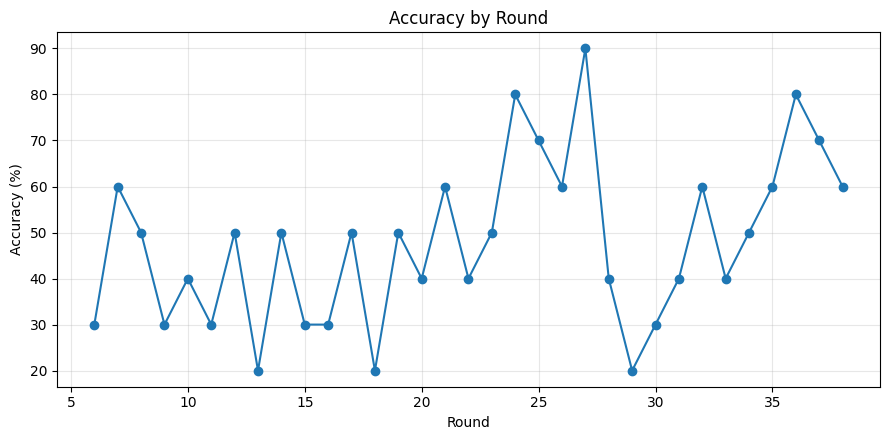

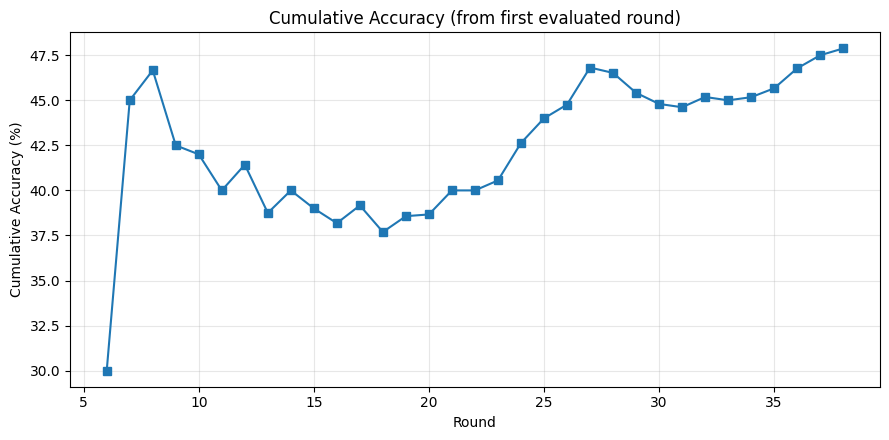


Overall accuracy (rounds 6–38): 0.479
Text summary: The model achieved an overall accuracy of 47.9% across rounds 6–38.

Classification report (labels: H=1, D=0, A=-1):
              precision    recall  f1-score   support

           1      0.622     0.520     0.566       152
           0      0.224     0.208     0.216        72
          -1      0.471     0.604     0.529       106

    accuracy                          0.479       330
   macro avg      0.439     0.444     0.437       330
weighted avg      0.487     0.479     0.478       330


Confusion matrix (rows=actual, cols=predicted) [H=1, D=0, A=-1]:
[[79 30 43]
 [28 15 29]
 [20 22 64]]


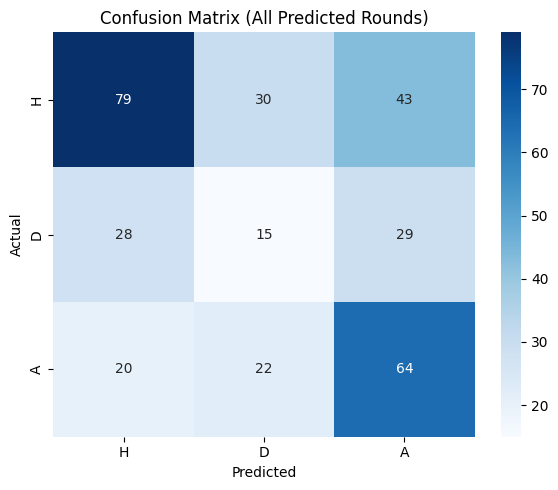

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Build DataFrame with predictions collected in point 5
res = pd.DataFrame({
    'Round': rounds,
    'Pred': preds,
    'True': actuals
}).sort_values('Round')

# Safety: check that every evaluated round has exactly 10 matches
round_sizes = res.groupby('Round').size()
if not np.all(round_sizes.values == 10):
    print("WARNING: Some rounds do not have exactly 10 matches in the evaluation:")
    print(round_sizes[round_sizes != 10])

# Per-round accuracy (guaranteed denominator is 10 if point 5 enforced it)
round_acc = res.groupby('Round').apply(lambda g: accuracy_score(g['True'], g['Pred']))
round_acc = round_acc.sort_index()

# Cumulative (running) accuracy across predicted rounds
# running_correct / running_total
res['Correct'] = (res['True'] == res['Pred']).astype(int)
cum = res.groupby('Round')['Correct'].sum().cumsum()
cum_total = np.arange(1, len(cum) + 1) * 10  # 10 matches per round by construction
cumulative_acc = (cum / cum_total).rename('CumulativeAccuracy')

# --- Plot: Accuracy by Round ---
plt.figure(figsize=(9, 4.5))
plt.plot(round_acc.index, round_acc.values * 100, marker='o')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Round')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: Cumulative Accuracy ---
plt.figure(figsize=(9, 4.5))
plt.plot(cumulative_acc.index, cumulative_acc.values * 100, marker='s')
plt.xlabel('Round')
plt.ylabel('Cumulative Accuracy (%)')
plt.title('Cumulative Accuracy (from first evaluated round)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Overall accuracy (text) ---
overall_acc = accuracy_score(res['True'], res['Pred'])
print(f"\nOverall accuracy (rounds {int(res['Round'].min())}–{int(res['Round'].max())}): {overall_acc:.3f}")
print(f"Text summary: The model achieved an overall accuracy of {overall_acc*100:.1f}% "
      f"across rounds {int(res['Round'].min())}–{int(res['Round'].max())}.")

# --- Classification report (informative only) ---
print("\nClassification report (labels: H=1, D=0, A=-1):")
print(classification_report(res['True'], res['Pred'], labels=[1,0,-1], digits=3))

# --- Confusion matrix (numbers + heatmap) ---
cm = confusion_matrix(res['True'], res['Pred'], labels=[1,0,-1])
print("\nConfusion matrix (rows=actual, cols=predicted) [H=1, D=0, A=-1]:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['H','D','A'], yticklabels=['H','D','A'])
plt.title('Confusion Matrix (All Predicted Rounds)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

8. Gradio Interface

In [8]:
import gradio as gr
import numpy as np
import pandas as pd

# ----------------------------------------------------------------------------
# Odds-like features: compute means from *training rounds only* (<= last_train_round)
# to avoid leaking information from the latest test rounds.
# ----------------------------------------------------------------------------
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]

# Guard: in case last_train_round isn't set for any reason, fall back safely
if 'last_train_round' not in globals():
    last_train_round = int(df['Round'].max()) - 1

train_df = df[df['Round'] <= last_train_round].copy()
odd_means = train_df[odd_feats].mean(numeric_only=True)

# ----------------------------------------------------------------------------
# Dropdown choices
# ----------------------------------------------------------------------------
teams = sorted(df['HomeTeam'].dropna().unique().tolist())
refs  = sorted(df['Referee'].dropna().unique().tolist())
times = ['Morning','Afternoon','Evening']

# ----------------------------------------------------------------------------
# Helper: fetch latest known rolling/state features for entities from training data
# ----------------------------------------------------------------------------
def _latest_row_for_team_side(team_name: str, side: str):
    """
    Return the last training row for a given team on the given side ('Home' or 'Away'),
    falling back to any occurrence in df if not present in training slice.
    """
    if side == 'Home':
        rows = train_df[train_df.HomeTeam == team_name]
        if len(rows) == 0:
            rows = df[df.HomeTeam == team_name]
    else:
        rows = train_df[train_df.AwayTeam == team_name]
        if len(rows) == 0:
            rows = df[df.AwayTeam == team_name]
    return rows.iloc[-1] if len(rows) else None

def _latest_row_for_ref(ref_name: str):
    rows = train_df[train_df.Referee == ref_name]
    if len(rows) == 0:
        rows = df[df.Referee == ref_name]
    return rows.iloc[-1] if len(rows) else None

# ----------------------------------------------------------------------------
# Prediction function
# ----------------------------------------------------------------------------
def predict_outcome(home_team, away_team, referee, time_of_day):
    # Basic guards
    if home_team == away_team:
        return "Pick two different teams.", 0.0, 0.0, 0.0

    # Latest known states
    home_row = _latest_row_for_team_side(home_team, 'Home')
    away_row = _latest_row_for_team_side(away_team, 'Away')
    ref_row  = _latest_row_for_ref(referee)

    if home_row is None or away_row is None or ref_row is None:
        return "Insufficient historical data to build features.", 0.0, 0.0, 0.0

    # Assemble one-row feature dict using training means for odds-like features
    feat = {}

    # Odds-like features from training means (leakage-safe defaults)
    for f in odd_feats:
        feat[f] = float(odd_means.get(f, np.nan))

    # Interaction term recomputed from mean probs (keeps algebra consistent)
    feat['OddsSpread']  = float(feat['ImpProb_H'] - feat['ImpProb_A'])
    feat['Spread×Form'] = float(feat['OddsSpread'] * (home_row.get('HomeForm3') if pd.notna(home_row.get('HomeForm3')) else 0.0))

    # Rolling forms & streaks
    feat['HomeForm3']  = float(home_row.get('HomeForm3', 0.0)) if pd.notna(home_row.get('HomeForm3')) else 0.0
    feat['AwayForm3']  = float(away_row.get('AwayForm3', 0.0)) if pd.notna(away_row.get('AwayForm3')) else 0.0
    feat['HomeStreak'] = float(home_row.get('HomeStreak', 0.0)) if pd.notna(home_row.get('HomeStreak')) else 0.0
    feat['AwayStreak'] = float(away_row.get('AwayStreak', 0.0)) if pd.notna(away_row.get('AwayStreak')) else 0.0

    # Referee bias & H2H last (fallbacks)
    feat['RefBias']  = float(ref_row.get('RefBias', 0.5)) if pd.notna(ref_row.get('RefBias')) else 0.5
    feat['H2H_Last'] = 0.0
    mask = (
        ((df.HomeTeam == home_team) & (df.AwayTeam == away_team)) |
        ((df.HomeTeam == away_team) & (df.AwayTeam == home_team))
    )
    if mask.any():
        last_h2h = df.loc[mask].iloc[-1].get('H2H_Last', 0.0)
        if pd.notna(last_h2h):
            feat['H2H_Last'] = float(last_h2h)

    # Previous-round positions
    feat['HomePosPrev'] = float(home_row.get('HomePosPrev', df['Round'].max() + 1))
    feat['AwayPosPrev'] = float(away_row.get('AwayPosPrev', df['Round'].max() + 1))

    # Rolling team statistics (3-match means)
    for s in ['HS','HST','HF','HC','HY','HR']:
        key = f'Home_{s}_3'
        feat[key] = float(home_row.get(key, 0.0)) if pd.notna(home_row.get(key)) else 0.0
    for s in ['AS','AST','AF','AC','AY','AR']:
        key = f'Away_{s}_3'
        feat[key] = float(away_row.get(key, 0.0)) if pd.notna(away_row.get(key)) else 0.0

    # Categoricals
    feat['HomeTeam']  = home_team
    feat['AwayTeam']  = away_team
    feat['Referee']   = referee
    feat['TimeOfDay'] = time_of_day

    # Build DataFrame and predict with the final pipeline
    X_new = pd.DataFrame([feat], columns=cat_feats + num_feats)
    proba = final_model.predict_proba(X_new)[0]

    # Map probabilities to Home/Draw/Away consistently with class order
    class_order = list(final_model.classes_)  # e.g. [-1, 0, 1]
    prob_map = {cls: p for cls, p in zip(class_order, proba)}

    home_pct = float(prob_map.get(1, 0.0) * 100.0)
    draw_pct = float(prob_map.get(0, 0.0) * 100.0)
    away_pct = float(prob_map.get(-1, 0.0) * 100.0)

    # Human-readable summary line
    summary = (f"{home_team} vs {away_team} | Ref: {referee} | {time_of_day} | "
               f"Home: {home_pct:.1f}%  Draw: {draw_pct:.1f}%  Away: {away_pct:.1f}%")
    return summary, home_pct, draw_pct, away_pct

# Gradio interface
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(choices=teams, label="Home Team"),
        gr.Dropdown(choices=teams, label="Away Team"),
        gr.Dropdown(choices=refs,  label="Referee"),
        gr.Dropdown(choices=times, label="Time of Day")
    ],
    outputs=[
        gr.Textbox(label="Summary"),
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %")
    ],
    title="Premier League Outcome Predictor (Bayesian + NN Hybrid)",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds-like features default to training-set historical averages; "
        "all other features are derived from the most recent training data."
    )
)

# Launch (you can set share=True if you need an external link)
iface.launch()


* Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.
